In [1]:
!pip install rdkit-pypi

In [2]:
# Import the main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import Draw, MolFromSmiles, MolToSmiles
import matplotlib.colors as mcolors
from matplotlib import cm
from collections import Counter
from itertools import chain
from rdkit.Chem import rdDepictor

# count co-formers frequency

In [3]:
# Import the co-crystals dataset
cocrystals = pd.read_csv('/content/csd_cocrystals2020.csv', encoding='latin1')

In [4]:
# Sort the co-formers based on molecular weight

def feature_first(a, b, w_a, w_b):
    ''' Sorting the smiles strings by having the heavier first '''
    f, s = (a, b) if w_a > w_b else (b,a)
    return f,s

def feature_apply(smi):
    return feature_first(smi[0], smi[1], Chem.Descriptors.MolWt(Chem.MolFromSmiles(smi[0])), 
    Chem.Descriptors.MolWt(Chem.MolFromSmiles(smi[1])))

def get_sorted_dataset():
  smiles=[]
  for i,j in enumerate(cocrystals.csd_id.values[:]):
    smi1 = cocrystals.smiles1.values[i]
    smi2 = cocrystals.smiles2.values[i]
    smi = [smi1, smi2]
    smiles.append(feature_apply(smi))
  return pd.DataFrame(smiles, columns=['smiles1', 'smiles2'])

def print_molecules(smiles):
  keys, counts = np.unique(smiles, return_counts=True)
  mols = pd.concat([pd.DataFrame(keys, columns=['name']), pd.DataFrame(counts, columns=['counts'])],axis=1)
  mol = mols.sort_values(by=['counts'], ascending=False)
  mol_list = [Chem.MolFromSmiles(smiles) for smiles in mol.name.values[:10]]
  fig=Chem.Draw.MolsToGridImage(mol_list, molsPerRow=5,legends= ['Count : %s'%i for i in mol.head(10).counts] , subImgSize=(150,150))
  return fig

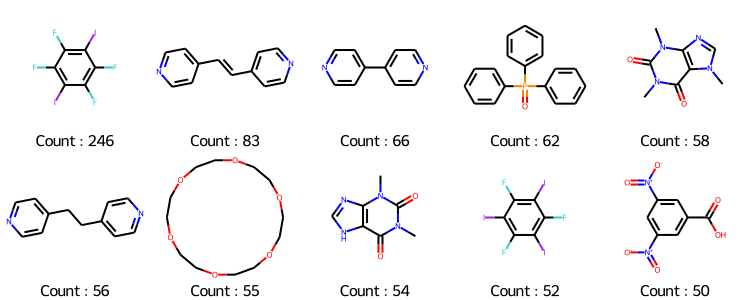

In [5]:
df = get_sorted_dataset()

print_molecules(df.smiles1.values)

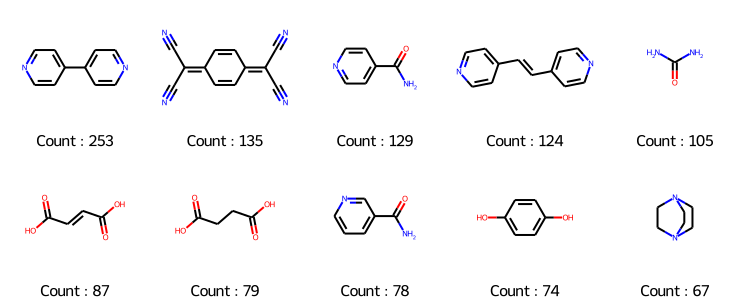

In [6]:
print_molecules(df.smiles2.values)

In [7]:
average_len=[]
for i in range(len(cocrystals.smiles1.values)):
  average_len.append((len(cocrystals.smiles1.loc[i]) + len(cocrystals.smiles2.loc[i])))

In [8]:
cocrystals['len'] = average_len
cocrystals

,csd_id,name,smiles1,smiles2,year,functionality,group,len
0,IANNOB,p-Iodoaniline-S-trinitrobenzene complex,Nc1ccc(I)cc1,O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O,1943,weak_bond,1,45
1,CLAHMB,Chloranil-hexamethylbenzene complex,ClC1=C(Cl)C(=O)C(=C(Cl)C1=O)Cl,Cc1c(C)c(C)c(C)c(C)c1C,1962,weak_bond,1,52
2,MTHMAD,9-Methyladenine-1-methylthymine complex,CN1C=Nc2c(N)ncnc12,CN1C=C(C)C(=O)NC1=O,1963,h-bond,2,37
3,PERFAN,Perylene-fluoranil complex,c1cc2cccc3c4cccc5cccc(c(c1)c23)c45,FC1=C(F)C(=O)C(=C(F)C1=O)F,1963,weak_bond,1,60
4,ANCTNB,Anthracene trinitrobenzene,c1ccc2cc3ccccc3cc2c1,O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O,1964,weak_bond,1,53
...,...,...,...,...,...,...,...,...
7474,UKITEQ,"3-(3,4,5-trimethoxyphenyl)prop-2-enoic acid se...",Cc1cccc2SC(=Nc12)N,COc1cc(C=CC(O)=O)cc(OC)c1OC,2021,h-bond,2,45
7475,UKITUG,"hemikis(decanedioic acid) 4-methyl-1,3-benzoth...",Cc1cccc2SC(=Nc12)N,OC(=O)CCCCCCCCC(O)=O,2021,h-bond,2,38
7476,UKIVIW,"4-methyl-1,3-benzothiazol-2-amine hemikis(buta...",Cc1cccc2SC(=Nc12)N,OC(=O)CC(C(CC(O)=O)C(O)=O)C(O)=O,2021,h-bond,2,50
7477,ULECEW,"4-phenyl-4H-4Ì?åÈ5-phospholo[3,2-b:4,5-b']bist...",O=P1(c2ccccc2)C2=C(SC=C2)C2=C1C=CS2,Oc1c(O)c(Cl)c(Cl)c(Cl)c1Cl,2021,h-bond,2,61


In [11]:
keys = cocrystals.year.values
val = cocrystals.groupby(cocrystals.year)['len'].transform('mean')
items = dict(zip(keys, val))
items.values()
p=cocrystals['year'].value_counts()

In [17]:
data = pd.concat([pd.DataFrame(p.index, columns=['year']),pd.DataFrame(p.values, columns=['counts'])], axis=1)
data = data.sort_values(by=['year'])
data = data[data.year<2021]

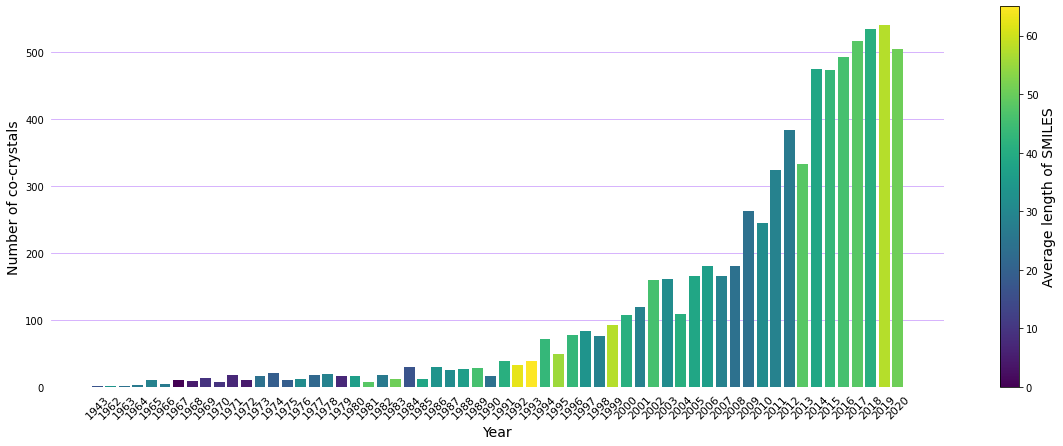

In [20]:
fig, ax = plt.subplots(figsize=(20,7))
x = data.year.values
counts = data.counts.values
x_pos = [i for i, _ in enumerate(x)]

y = [int(items[i]) for i in x]
cy = [(i-min(y))/(max(y)-min(y)) for i in y]
my_cmap = plt.cm.get_cmap('viridis')
colors = my_cmap(cy)
from matplotlib.cm import ScalarMappable
ax.bar(x_pos, counts, color=colors)#
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(y)))

sm.set_array([])
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average length of SMILES', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False) 
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#cea2fd')
ax.xaxis.grid(False)
ax.set_facecolor('white')
fig.patch.set_visible(False)
ax.axis('on')

plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of co-crystals", fontsize=14)
ax.xaxis.set_tick_params(rotation=45)
plt.xticks(x_pos, x, fontsize=11)
#plt.savefig('/content/fig.svg', dpi=600,bbox_inches='tight')
plt.show()

In [23]:
pub_stats = pd.read_csv('/literature_data/cocrystal_publication_statistics.csv')

In [24]:
pub_stats=pub_stats.sort_values(by='year')
pub_stats = pub_stats[pub_stats.year> 1990]

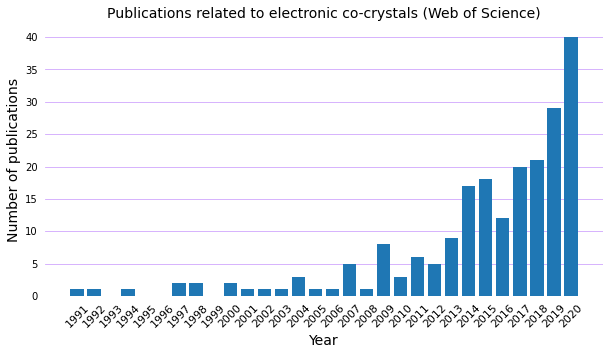

In [25]:
plt.rc('font', family='Open Sans')
fig, ax = plt.subplots(figsize=(10,5))
x = pub_stats.year.values
statistics = pub_stats.publications_cocrystal_electronic.values
x_pos = [i for i, _ in enumerate(x)]
ax.bar(x_pos, statistics)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#cea2fd') 
ax.xaxis.grid(False)
ax.set_facecolor('white')
fig.patch.set_visible(False)
ax.axis('on')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of publications", fontsize=14)
ax.xaxis.set_tick_params(rotation=45)
plt.xticks(x_pos, x, fontsize=11)
plt.title('Publications related to electronic co-crystals (Web of Science)', fontsize=14)
#plt.savefig('web_of_science_fig.png', dpi=600,bbox_inches='tight')
plt.show()